In [2]:
import ipyparallel as ipp
#
NCPU = 4
cluster = ipp.Cluster(engines="mpi", n=NCPU)
client = cluster.start_and_connect_sync()
#
client.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.47s/engine]


[0, 1, 2, 3]

In [3]:
%%px
#client.wait_for_engines(6)
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
#
# Start Intracommunicator and get what is out there i.t.o. size and rank
# Note that all these variables are known to all ranks where size is equal
# for all and rank is specific to the rank number of the process.
#
comm = MPI.COMM_WORLD      # start the communicator assign to comm
size = comm.Get_size()     # get the size and assign to size
rank = comm.Get_rank()     # get the rank and assign to rank
#
# This is just for checking if it worked and should give sth. like this:
#[stdout:3] Rank/Size 3/16
#
#[stdout:5] Rank/Size 5/16
#
#[stdout:10] Rank/Size 10/16
#
#[stdout:0] Rank/Size 0/16
#
#[stdout:1] Rank/Size 1/16
#
#print('Rank/Size {}/{}'.format(rank,size))    

In [4]:
%%px
dx = 0.1     # = dy
nt = 100000  # timesteps to iterate
dt = 0.0001   # timestep length
D = 1        # diffusion constant

## 2D Domain decomposition

In [5]:
%%px
#
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
#
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
#
# Let us take a square simulation domain that can be divided 
# by the number of cores and results in a square subdomain 
NX = 400
NY = 400
#
#print('NX = {} NY = {}, and sqrt(NX*NY) = {}'.format(NX,NY,np.sqrt(NX*NY)))
#print('NX/NY = {} and NY/NX = {}\n'.format(NX/NY,NY/NX))
#
if NX < NY:
    sectsX=int(np.floor(np.sqrt(size*NX/NY)))
    sectsY=int(np.floor(size/sectsX))
    print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
    print('How do the fractions look like?')
    print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
elif NX > NY:
    sectsY=int(np.floor(np.sqrt(size*NY/NX)))
    sectsX=int(np.floor(size/sectsY))
    print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
    print('How do the fractions look like?')
    print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
elif NX==NY:
    sectsY=int(np.floor(np.sqrt(size)))
    sectsX=int(size/sectsY)
    if rank == 0: print('In the case of equal size we divide the processes as {} and {}'.format(sectsX,sectsY))
#
#print('Rank {}/{} is alive.'.format(rank, size))
#
sectsX=int(np.floor(np.sqrt(size)))
sectsY=int(size//sectsX)
#
#sectsX=int(sys.argv[3])
#sectsY=int(sys.argv[4])
nxsub = NX//sectsX+2
nysub = NY//sectsY+2
boundary_k=[False,False,False,False]
cartcomm=comm.Create_cart(dims=[sectsX,sectsY],periods=[True,True],reorder=False)
rcoords = cartcomm.Get_coords(rank)
#
# where to receive from and where send to 
sR,dR = cartcomm.Shift(1,1)
sL,dL = cartcomm.Shift(1,-1)
#sU,dU = cartcomm.Shift(0,1)
#sD,dD = cartcomm.Shift(0,-1)
sU,dU = cartcomm.Shift(0,-1)
sD,dD = cartcomm.Shift(0,1)
#
sd = np.array([sR,dR,sL,dL,sU,dU,sD,dD], dtype = int)

[stdout:0] In the case of equal size we divide the processes as 4 and 4


## Analysis of the domain

In [6]:
%%px
if rank == 0: print(allrcoords)

[0:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[4], line 1
----> 1 if rank == 0: print(allrcoords)

NameError: name 'allrcoords' is not defined


AlreadyDisplayedError: 1 errors

In [7]:
%%px
allrcoords = comm.gather(rcoords,root = 0)
allDestSourBuf = np.zeros(size*8, dtype = int)
comm.Gather(sd, allDestSourBuf, root = 0)
#
#print(sd)
if rank == 0:
    print(' ')
    cartarray = np.ones((sectsY,sectsX),dtype=int)
    allDestSour = np.array(allDestSourBuf).reshape((size,8))
    for i in np.arange(size):
        cartarray[allrcoords[i][0],allrcoords[i][1]] = i
        print('Rank {} all destinations and sources {}'.format(i,allDestSour[i,:]))
        sR,dR,sL,dL,sU,dU,sD,dD = allDestSour[i]
        print('Rank {} is at {}'.format(i,allrcoords[i]))
        print('sour/dest right {} {}'.format(sR,dR))
        print('sour/dest left  {} {}'.format(sL,dL))  
        print('sour/dest up    {} {}'.format(sU,dU))
        print('sour/dest down  {} {}'.format(sD,dD))
        #print('[stdout:',i,']',allDestSour[i])
    print('')
    print(cartarray)

[stdout:0]  
Rank 0 all destinations and sources [ 3  1  1  3  4 12 12  4]
Rank 0 is at [0, 0]
sour/dest right 3 1
sour/dest left  1 3
sour/dest up    4 12
sour/dest down  12 4
Rank 1 all destinations and sources [ 0  2  2  0  5 13 13  5]
Rank 1 is at [0, 1]
sour/dest right 0 2
sour/dest left  2 0
sour/dest up    5 13
sour/dest down  13 5
Rank 2 all destinations and sources [ 1  3  3  1  6 14 14  6]
Rank 2 is at [0, 2]
sour/dest right 1 3
sour/dest left  3 1
sour/dest up    6 14
sour/dest down  14 6
Rank 3 all destinations and sources [ 2  0  0  2  7 15 15  7]
Rank 3 is at [0, 3]
sour/dest right 2 0
sour/dest left  0 2
sour/dest up    7 15
sour/dest down  15 7
Rank 4 all destinations and sources [7 5 5 7 8 0 0 8]
Rank 4 is at [1, 0]
sour/dest right 7 5
sour/dest left  5 7
sour/dest up    8 0
sour/dest down  0 8
Rank 5 all destinations and sources [4 6 6 4 9 1 1 9]
Rank 5 is at [1, 1]
sour/dest right 4 6
sour/dest left  6 4
sour/dest up    9 1
sour/dest down  1 9
Rank 6 all destinations

## Initial conditions 2D

In [8]:
%%px
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
#nx = 1600
dx = 0.1
nt = 10000
dt = 0.001
D = 1 # diffusion constant
# Define the gridpoints
x = np.arange(rcoords[0]*NX//sectsX,(rcoords[0]+1)*NX//sectsX)*dx
y = np.arange(rcoords[1]*NY//sectsX,(rcoords[1]+1)*NY//sectsY)*dx
X,Y = np.meshgrid(x,y)
#
sigma0 = 30*dx
c = np.zeros((nxsub,nysub))
c[1:-1,1:-1] = np.exp(-((X-NX/2*dx)**2+(Y-NY/2*dx)**2)/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)

## Plot gathered data

[output:0]

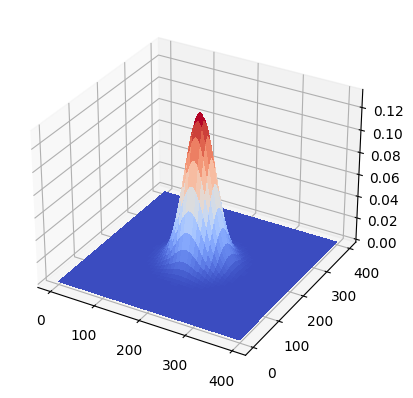

In [9]:
%%px
#
c_full_range = np.zeros((NX*NY))
comm.Gather(c[1:-1,1:-1].reshape((nxsub-2)*(nysub-2)), c_full_range, root = 0)
rcoords_x = comm.gather(rcoords[0], root=0)
rcoords_y = comm.gather(rcoords[1], root=0)
if rank == 0:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#
    X0, Y0 = np.meshgrid(np.arange(NX),np.arange(NY))
    xy = np.array([rcoords_x,rcoords_y]).T
    c_plot = np.zeros((NX,NY))
    #
    for i in np.arange(sectsX):
        for j in np.arange(sectsY):
            k = i*sectsX+j
            xlo = NX//sectsX*xy[k,1]
            xhi = NX//sectsX*(xy[k,1]+1)
            ylo = NY//sectsY*xy[k,0]
            yhi = NY//sectsY*(xy[k,0]+1)
            clo = k*NX*NY//(sectsX*sectsY)
            chi = (k+1)*NX*NY//(sectsX*sectsY)
            #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
            #print((xhi-xlo)*(yhi-ylo),chi-clo)
            c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//sectsX,NY//sectsY)
#            
    ax.plot_surface(X0, Y0, c_plot, cmap=cm.coolwarm,linewidth=0, antialiased=False)
#

## Set up communication

In [10]:
%%px
# sR,dR,sL,dL,sU,dU,sD,dD
if rank == 0: print(sd)
if rank == 0: 
    print('')
    print(cartarray)

[stdout:0] [ 3  1  1  3  4 12 12  4]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [11]:
%%px
# Communication between subdomains
def Communicate(c,cartcomm,sd):
    recvbuf = np.zeros(c[:,1].shape[0])
    sR,dR,sL,dL,sU,dU,sD,dD = sd
    # Send to right which is destination rigth (dR) and receive from left which is source right (sR)
    # print(rank,'Right, source',sR,'destination',dR)
    sendbuf = c[:,-2].copy() # Send the second last column to dR
    cartcomm.Sendrecv(sendbuf, dR, recvbuf = recvbuf, source = sR)
    c[:,0] = recvbuf # received into the 0th column from sR
    # Send to left and receive from right
    #print(rank,'Left, source',sL,'destination',dL)
    sendbuf = c[:,1].copy()
    cartcomm.Sendrecv(sendbuf, dL, recvbuf = recvbuf, source = sL)
    c[:,-1] = recvbuf
    # Send to up and receive from down
    #print(rank,'Up, source',sU,'destination',dU)
    sendbuf = c[1,:].copy()
    cartcomm.Sendrecv(sendbuf, dU, recvbuf = recvbuf, source = sU)
    c[-1,:] = recvbuf
    # Send to down and receive from up
    #print(rank,'Down, source',sD,'destination',dD)
    sendbuf = c[-2,:].copy()
    cartcomm.Sendrecv(sendbuf, dD, recvbuf = recvbuf, source = sD)
    c[0,:]=recvbuf
#
    return c

In [ ]:
#%%px
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.plot_surface(X, Y, c[1:-1,1:-1], cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [12]:
%%px
# The time stepping loop
for t in np.arange(nt):
    # First we need a communication step
    c = Communicate(c,cartcomm,sd)
    # Then we do a timestep forward
    cup = (np.roll(c,shift=(1,0),axis=(0,1)).copy())[1:-1,1:-1]
    cdown = (np.roll(c,shift=(-1,0),axis=(0,1)).copy())[1:-1,1:-1]
    cleft = (np.roll(c,shift=(0,1),axis=(0,1)).copy())[1:-1,1:-1]
    crght = (np.roll(c,shift=(0,-1),axis=(0,1)).copy())[1:-1,1:-1]
    ccent = c.copy()[1:-1,1:-1]
    c[1:-1,1:-1] = c[1:-1,1:-1] + D*dt/dx**2*(cleft+cdown -4.*ccent+crght+cup)

%px: 100%|██████████| 16/16 [00:19<00:00,  1.23s/tasks]


[output:0]

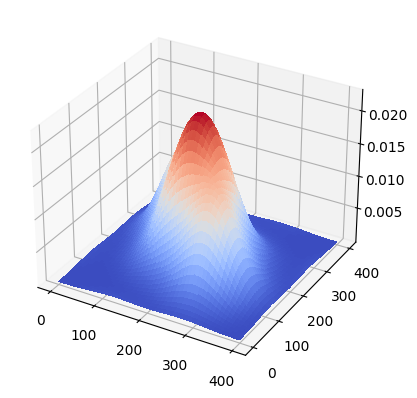

In [13]:
%%px
# Then let's plot
# first all the individual plots
#ax.plot_surface(X0, Y0, c_plot, cmap=cm.coolwarm,linewidth=0, antialiased=False)

#
c_full_range = np.zeros((NX*NY))
comm.Gather(c[1:-1,1:-1].reshape((nxsub-2)*(nysub-2)), c_full_range, root = 0)
rcoords_x = comm.gather(rcoords[1], root=0)
rcoords_y = comm.gather(rcoords[0], root=0)
if rank == 0:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#
    X0, Y0 = np.meshgrid(np.arange(NX),np.arange(NY))
    xy = np.array([rcoords_x,rcoords_y]).T
    c_plot = np.zeros((NX,NY))
    #
    for i in np.arange(sectsX):
        for j in np.arange(sectsY):
            k = i*sectsX+j
            xlo = NX//sectsX*xy[k,1]
            xhi = NX//sectsX*(xy[k,1]+1)
            ylo = NY//sectsY*xy[k,0]
            yhi = NY//sectsY*(xy[k,0]+1)
            clo = k*NX*NY//(sectsX*sectsY)
            chi = (k+1)*NX*NY//(sectsX*sectsY)
            #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
            #print((xhi-xlo)*(yhi-ylo),chi-clo)
            c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//sectsX,NY//sectsY)
#            
    ax.plot_surface(X0, Y0, c_plot, cmap=cm.coolwarm,linewidth=0, antialiased=False)

In [ ]:
client.shutdown()

In [14]:
%%px
if rank == 0:
    print(rcoords_x)
    print(rcoords_y)

[stdout:0] [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]


In [ ]:
%%px
print(rcoords)